The source code for this project could be found [here](https://github.com/Xianzhiwang1/ml-0451-final-proj). 



Let us import some libraries that we are going to use.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from final_project_code import FinalProject 

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from matplotlib.patches import Patch

In [7]:
FP = FinalProject()

# Predicting whether Russian Factories want to incorporate or not
We start our analysis by using logistic regression to predict what kind of firms in late Imperial Russia is more likely owned by a corporation.  


`$$\mathcal{L}(a, b) = \sum_{i = 1}^n (ax_i + b - y_i)^2$$` 

renders to: 

$$\mathcal{L}(a, b) = \sum_{i = 1}^n (ax_i + b - y_i)^2\;.$$

# get the data in

In [8]:
import pandas as pd

# train_url = "./../Vermont_farm_tables/1850Midd.csv"
# train = pd.read_csv(train_url)

We download the replication data set and put it in the same directory as our project. After we read in the data, we notice that there are $66$ columns, which means potentially we could have around $60$ features for our machine learning model. However, let's start small. Hence, we begin our analysis using a subset of the columns. Also, since in the original data set, there's only a small percentage of factories that are incorporated, which is because of historical reasons in Late Imperial Russia during 1894 to 1908. For the purpose of this machine learning project, we artificially select a subset of the whole data set so that we have equal number of factories owned by incorporated firms and not incorporated firms alike.

In [9]:
# Rvss = pd.io.stata.read_stata("./../Rvssian/AG_Corp_RuscorpMasterFile_Cleaned.dta")
# Rvss.to_csv("RvssianCorpMasterFileCleaned.csv")

In [10]:
# Rvss_data = pd.io.stata.read_stata("./AG_Corp_Prod_Database.dta")
# Rvss_data.to_csv("AG_Corp_Prod_DataBase.csv")

In [11]:
Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")

/tmp/ipykernel_2233/139095848.py:1: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")


In [12]:
Rvss.loc[Rvss['Form']==0]

,Unnamed: 0,id,Form,PSZ,PSZ1900,FoundingYear,Province,Region,Industry,OntheSide,...,Animal,Wool,Cotton,MixedMaterials,Wood,Paper,MetalsandMachines,Foods,Chemical,Mineral
0,0,4156,0,NaN,NaN,1860.0,30,CentralIndustrial,Paper,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,52010,0,NaN,NaN,NaN,51,Previslitskii,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,30937,0,NaN,NaN,NaN,41,CentralBlacksoil,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,39923,0,NaN,NaN,NaN,3,Caucasus,Metals and Machines,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,3296,0,NaN,NaN,1882.0,11,Northwestern,Chemicals,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37964,37964,34420,0,NaN,NaN,NaN,30,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37965,37965,34210,0,NaN,NaN,NaN,19,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37966,37966,52603,0,NaN,NaN,NaN,17,Southern,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37967,37967,4886,0,NaN,NaN,NaN,61,CentralIndustrial,Mineral Products,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
Rvss.columns

Index(['Unnamed: 0', 'id', 'Form', 'PSZ', 'PSZ1900', 'FoundingYear',
       'Province', 'Region', 'Industry', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'Metalsa

In [14]:
df = Rvss[['id', 'Form', 'FoundingYear',
       'Province', 'Region', 'Industry', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']]

In [15]:
df_inc = df.loc[df['Form'] == 1]

In [16]:
df_not_inc = df.loc[df['Form'] == 0]

In [17]:
print(f"df incorporated have {df_inc.shape[0]} many rows")

df incorporated have 2393 many rows


In [18]:
df_not_inc = df_not_inc.sample(n=2393, replace=False)

In [19]:
print(f"df not incorporated have {df_not_inc.shape[0]} many rows")
frames = [df_inc, df_not_inc]
result = pd.concat(frames)

df not incorporated have 2393 many rows


In [20]:
result['Form'].mean()

0.5

In [21]:
compression_opts = dict(method='zip', archive_name='artificially_balanced_Rvssian_Factory.csv')
result.to_csv('artificially_balanced_Rvssian_Factory.zip', index = False, compression=compression_opts)

In [22]:
result = result.sample(frac=1).reset_index(drop=True)

In [23]:
# result.head(10)

In [24]:
FP = FinalProject()
train, validate, test = FP.split_data(result)

In [40]:
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

# First, we try some feature engineering
In the basic toolbox of an economist, one is unlikely to find methods of feature engineering, since we believe that economists would rather choose the regressors (features) themselves, becuase regressors are often central to the economic questoin and analysis. However, in this project, we actually going to have a systematic way written in code to select the features.

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(X_train["Region"])
RegionCoded = le.transform(X_train["Region"])
le.fit(X_train["Industry"])
IndustryCoded = le.transform(X_train["Industry"])

X_train['RegionCoded'] = RegionCoded
X_train['IndustryCoded'] = IndustryCoded 
X_train = X_train.drop(columns='Region', axis = 1)
X_train = X_train.drop(columns='Industry', axis = 1)

In [46]:
X_train = X_train.fillna(0)
X_train.head(10)

,id,FoundingYear,Province,OntheSide,Age,TaxedActivity,YEAR,PSZLastYear,PSZ1908,SubindustryCode,...,Cotton,MixedMaterials,Wood,Paper,MetalsandMachines,Foods,Chemical,Mineral,RegionCoded,IndustryCoded
2897,23151,0.0,30,0.0,10.0,0.0,1900.0,0,0,837.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,5
4435,36487,0.0,35,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,8
2309,17923,0.0,30,0.0,43.0,0.0,1900.0,0,0,111.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
763,36413,0.0,30,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,8
4397,27455,0.0,48,0.0,29.0,0.0,1900.0,0,0,1201.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
2694,36979,0.0,17,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,8
4500,16102,1878.0,50,0.0,17.0,0.0,1894.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,5
555,39057,0.0,11,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
2755,42767,0.0,38,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,11
33,36011,0.0,6,0.0,0.0,0.0,1908.0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,8


In [60]:
FP1 = FinalProject() 
all_qual_cols = ['RegionCoded', 'IndustryCoded'] 

all_quant_cols = [
      #  'Province', 'OntheSide', 'Age', 'TaxedActivity',
      #  'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower']
      #  'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
      #  'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
      #  'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
      #  'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
      #  'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
      #  'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
      #  'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
      #  'Chemical', 'Mineral']
y_train = y_train.reset_index(drop=True)
FP1.feature_combo(all_qual_cols, all_quant_cols, X_train, y_train)    

In [70]:
max(FP1.feature_score_pair, key=FP1.feature_score_pair.get)

('RegionCoded', 'RevperGrandWorker', 'logWorkers')

Hence, for fitting logistic regression on the training data, the highest scoring combination of 3 features among the independent variables that we considered is `RegionCoded`, `RevperGrandWorker`, `logWorkers`. 

In [73]:
# test for max 
max([-10, 5, 3], key=abs)
print(max(FP1.feature_score_pair.values()))
print(FP1.feature_score_pair[('RegionCoded', 'RevperGrandWorker', 'logWorkers')])

0.8077324973876698
0.8077324973876698


### The Prediction Question:
Can we predict which factory belongs to a incorporated company in Late Imerial Russia, during year 1894 and year 1908, by looking at other variables that are in the data? 

### Data Inspection
Since previously we have artificially selected a subset of our entire Russian factory data set so that we have equal number of factories belonging to incorporated firms and not incorporated firms, we expect that our label has roughly $50 \%$ of $1$'s and $50 \%$ % of $0$'s.

In [ ]:
y_train.mean()

0.49703935910832464

In [ ]:
df_train.groupby(['Industry'])[['Form']].aggregate([np.mean, len]).round(3)

Form     
                      mean  len
Industry                       
Animal               0.258  178
Chemicals            0.702  205
Cotton               0.787  356
Flax                 0.616   86
Foods A              0.247  453
Metals and Machines  0.604  485
Mineral Products     0.428  271
Mixed Materials      0.507   73
Paper                0.535  226
Silk                 0.250   56
Wood                 0.422  275
Wool                 0.459  207

Hence, it seems that Food industry in Late Imperial Russia had a low incorporation rate, which is around $28.3 \%$. On the other hand, the Cotton industry had a relatively high incorporation rate, around $81.4 \%$.

In [ ]:
df_train.groupby(['Industry'])[['TotalPower']].aggregate([np.mean, len]).round(3)

TotalPower     
                          mean  len
Industry                           
Animal                  37.310  178
Chemicals              240.731  205
Cotton                1210.561  356
Flax                   593.383   86
Foods A                 62.312  453
Metals and Machines    253.363  485
Mineral Products       121.442  271
Mixed Materials         97.164   73
Paper                  213.945  226
Silk                    22.500   56
Wood                    63.580  275
Wool                   205.213  207

We see that Cotton industry has the highest mean total power, and Silk industry has the lowest mean total power. We might predict that industry with a higher need for capital might choose to incorporate. 
### Running some regressions 
We start with the standard procedure in Econometrics, which is running regressions. We first perform some regression analysis that is close in spirit to the published paper where this replication data set is coming from, and   

In [ ]:


# this counts as 3 features because the two Clutch Completion 
# columns are transformations of a single original measurement. 
# you should find a way to automatically select some better columns
# as suggested in the code block above
cols = ["id", "FoundingYear", "Industry", "TotalWorkers", "TotalPower", "GrandTotalWorkers", "logWorkers", "Mineral"]
cols = ['id', 'FoundingYear',
       'Province', 'Region', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']
cols = ['id', 'FoundingYear', 'Province', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']
# X_train = X_train.dropna()
# X_train = X_train.drop(["Industry"], axis=1)
# X_train = X_train.drop(["Region"], axis=1)
# X_train.drop(["FoundingYear", "OntheSide", "TaxedActivity", "PSZLastYear", "PSZ1908"], axis=1)
X_train = X_train.fillna(0)
y_train.reset_index(drop=True)
cols = ["TotalWorkers", "TotalPower", "Revenue", "Age", 
        "Silk", "Flax", "Animal", "Wool", "Cotton", "MixedMaterials", 
        "Wood", "Paper", "MetalsandMachines", "Foods", "Chemical", "Mineral"]

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.6464646464646465

In [ ]:
X_train[cols]

,TotalWorkers,TotalPower,Revenue,Age,Silk,Flax,Animal,Wool,Cotton,MixedMaterials,Wood,Paper,MetalsandMachines,Foods,Chemical,Mineral
2897,50.0,0.0,31400.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4435,22.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2309,52.0,0.0,89900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
763,99.0,0.0,207800.0,32.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4397,22.0,0.0,18300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,36.0,0.0,6677.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3790,7.0,0.0,18000.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3980,131.0,0.0,83206.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1706,16.0,2.0,21778.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
pd.DataFrame({
    "column": X_train[cols].columns,
    "coefficient": LR.coef_.ravel()
})

,column,coefficient
0,TotalWorkers,0.002543
1,TotalPower,-0.000432
2,Revenue,0.000001
3,Age,-0.018715
4,Silk,-0.000046
5,Flax,-0.000030
6,Animal,-0.000121
7,Wool,-0.000127
8,Cotton,-0.000055
9,MixedMaterials,-0.000012


/home/xianzhiwang/ml0451/ml-0451-final-proj/final-blog-post/final_project_code.py:70: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


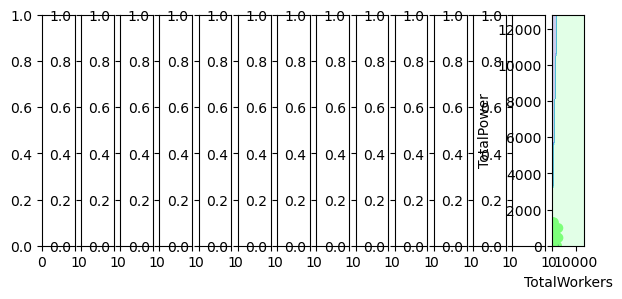

In [ ]:
# need to write up the function that make a visual representation
FP.plot_regions(LR, X_train[cols], y_train)

#### Now we try Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
def poly_LR(deg):
    return Pipeline([("poly", PolynomialFeatures(degree=deg)),
                     ("LR", LogisticRegression(penalty="none", max_iter=int(1e3)))])

In [ ]:
plr = poly_LR(1)
plr.fit(X_train[cols], y_train)
plr.score(X_train[cols], y_train)

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.6509926854754441

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
cv_scores

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past beha

array([0.62782609, 0.5       , 0.64634146, 0.50696864, 0.6445993 ])

In [ ]:
cv_scores.mean()

0.5851470989244054

Hence, this is telling us that for the features we selected, polynomial logistic regression has roughly the same predictive power as simply guessing whether a factory is belonging to a corporation or not. Degree zero corresponds to the baseline model, and degree 1 corresponds to simple logistic regression without a polynomial feature map.

In [ ]:
for deg in range(3):
    plr = poly_LR(deg = deg)
    cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
    mean_score = cv_scores.mean()  
    print(f"Polynomial degree = {deg}, score = {mean_score.round(3)}")

In [ ]:
X_test = X_test.fillna(0)
plr.score(X_test[cols], y_test).round(4)

0.6378

In [ ]:
from sklearn.metrics import confusion_matrix
y_predict = plr.predict(X_test[cols])
confusion_matrix(y_test, y_predict)

array([[201, 304],
       [ 43, 410]])

In [ ]:
confusion_matrix(y_test, y_predict, normalize = "true")

array([[0.3980198 , 0.6019802 ],
       [0.09492274, 0.90507726]])

In [ ]:
X_test["PowerperWorker"].mean()

0.6348312793559499

In [ ]:
ix = X_test["PowerperWorker"] > 0.63483127
print("Factories with more power per worker than average")
print(f"The percentage our prediction is correct: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix], normalize="true")

Factories with more power per worker
The percentage our prediction is correct: 0.618421052631579


array([[0.23584906, 0.76415094],
       [0.04918033, 0.95081967]])

In [ ]:

ix = X_test["PowerperWorker"] < 0.63483127
print("Factories with less power per worker than average")
print(f"The percentage our prediction matches the actual label: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix], normalize="true")

Factories with less power per worker than average
The percentage our prediction matches the actual label: 0.6438356164383562


array([[0.44110276, 0.55889724],
       [0.11178248, 0.88821752]])

In [ ]:
y_test[X_test["PowerperWorker"] > 0.63483127]

827     0
984     0
4758    0
4420    1
3908    1
       ..
130     0
2919    1
3171    0
4426    1
860     0
Name: Form, Length: 228, dtype: int64